## Bibliotecas

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl as opx
import scipy.optimize as scy
from functools import partial

## Importando Arquivo de dados


In [33]:
df=pd.read_excel(r'E:\eduro\Documents\Graduação ITA\Iniciação científica\Dados-impedancia.xlsx')

In [34]:
#importando excel
wb=opx.load_workbook(r'E:\eduro\Documents\Graduação ITA\Iniciação científica\Dados-impedancia.xlsx')
#abrindo página de localização da tabela
ws=wb['arg03']

In [35]:
def create_df_from_excel(ws,nome_da_tabela):
    mapping = {}

    for entry, data_boundary in ws.tables.items():
        #parse the data within the ref boundary
        data = ws[data_boundary]
        #extract the data 
        #the inner list comprehension gets the values for each cell in the table
        content = [[cell.value for cell in ent] 
                for ent in data
            ]
        header = content[0]
        #the contents ... excluding the header
        rest = content[1:]
        #create dataframe with the column names
        #and pair table name with dataframe
        df = pd.DataFrame(rest, columns = header)
        mapping[entry] = df
    return mapping[nome_da_tabela]


In [36]:
df=create_df_from_excel(ws,'graf_03')
df.dropna(how='all',inplace=True)

In [37]:
df.rename(columns={'Column1':'Frequency','Column2':'Impedance','Column3':'Phase'},inplace=True)
df.drop(columns={'Column4','Column5'},inplace=True)

## Criação de Colunas


In [38]:
df['Phase_Rad']=np.radians(df['Phase'])
df.rename(columns={'Phase':'Phase_degree'},inplace=True)

In [39]:
df['Omega']=2*np.pi*df['Frequency']

In [40]:
df['Impedance_Real']=df['Impedance']*np.cos(df['Phase_Rad'])
df['Impedance_Imaginary']=np.abs(df['Impedance']*np.sin(df['Phase_Rad']))

Text(0, 0.5, 'Impedância Imaginária')

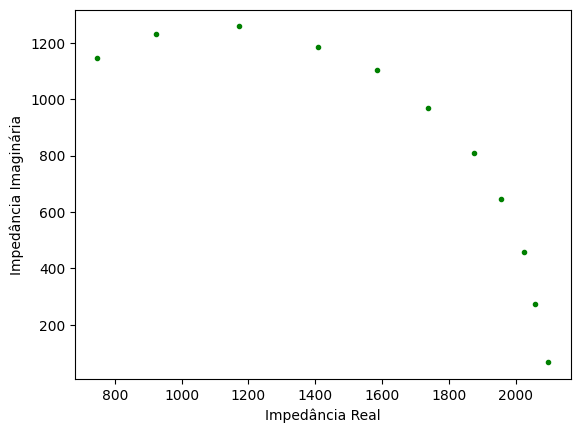

In [41]:
fig, axs = plt.subplots(1, 1)
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'g.')
plt.xlabel('Impedância Real')
plt.ylabel('Impedância Imaginária')

## Funções para calcular a melhor curva

In [94]:
def func_real(w,R,t,a):
    f=R*(1+np.cos((1-a)*np.pi/2)*(w*t)**(1-a))/(1+ (w*t)**(2-2*a) +2*np.cos((1-a)*np.pi/2)*(w*t)**(1-a))
    return f
def func_im(w,R,t,a):
    f=np.abs(-1*R*(np.sin((1-a)*np.pi/2)*(w*t)**(1-a))/(1+ (w*t)**(2-2*a) +2*np.cos((1-a)*np.pi/2)*(w*t)**(1-a)))
    return f

## Tentativa de dar um guess nos parâmetros

In [95]:
def plotar(R,t,a,start,stop,len):
    xx=np.linspace(start,stop,num=len)
    z_im=func_im(xx,R,t,a)
    z_real=func_real(xx,R,t,a)
    plt.plot(abs(z_real),abs(z_im),'*')
    #axs.axis('equal')
    axs.grid()

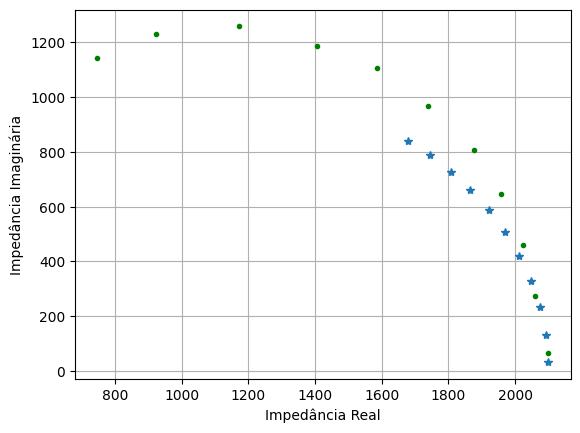

In [90]:
# a ideia foi chutar os parâmetros para ver o comportamento do diagrama de fase da curva
fig, axs = plt.subplots(1, 1)
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'g.')
plt.xlabel('Impedância Real')
plt.ylabel('Impedância Imaginária')
plotar(2100,1/2000000,0.000001,30000,1000000,len=11)
plt.show()

## Utilização do curve_fit para acertar os parâmetros

In [107]:
popt_real, pcov_real = scy.curve_fit(func_real, df.Omega, df.Impedance_Real,bounds=(0,[10**6,10**2,1]),maxfev=100000)


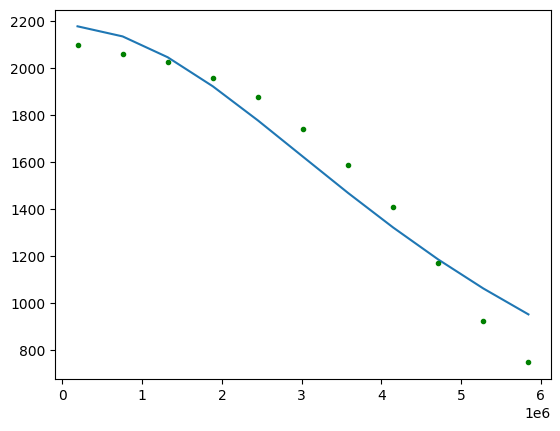

In [108]:
plt.plot(df.Omega,func_real(df.Omega,*popt_real))
plt.plot(df.Omega,df['Impedance_Real'],'g.')

In [75]:
popt_im, pcov_im=scy.curve_fit(func_im, df.Omega, df.Impedance_Imaginary,p0=popt_real,maxfev=100000,bounds=(0,[10**6,10**2,1]))
perr_im = np.sqrt(np.diag(pcov_im))

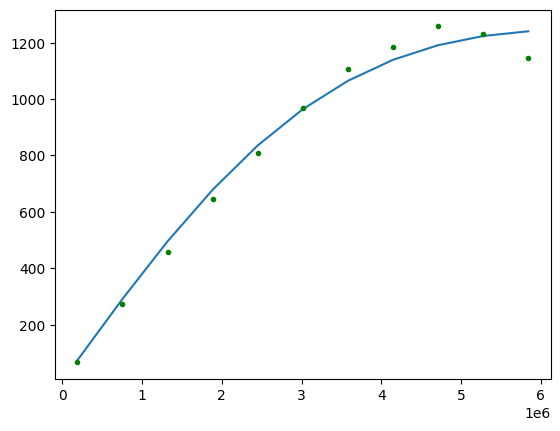

In [76]:
plt.plot(df.Omega,func_im(df.Omega,*popt_im))
plt.plot(df.Omega,df['Impedance_Imaginary'],'g.')

In [123]:
def fit_func_real(x, b,c):
    return func_real(x,popt_real[0] ,b, c)
def fit_func_im(x, b,c):
    return func_im(x,popt_real[0] ,b, c)

In [120]:
popt_real2, pcov_real2 = scy.curve_fit(fit_func_real, df.Omega, df.Impedance_Real,bounds=([0,popt_real[2]],[10**2,1]),maxfev=100000)


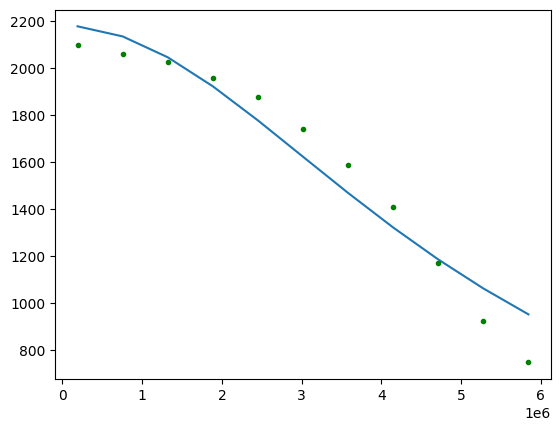

In [121]:
plt.plot(df.Omega,func_real(df.Omega,popt_real[0],*popt_real2))
plt.plot(df.Omega,df['Impedance_Real'],'g.')

## Loop para tentar achar a melhor aproximação para os parâmetros (saindo com a função real)

In [130]:
vec_popt_real=np.zeros([1001,2])
vec_popt_im=np.zeros([1001,2])

# Saindo com a função real

vec_popt_real_init, vec_pcov_real = scy.curve_fit(func_real, df.Omega, df.Impedance_Real,bounds=(0,[10**6,10**2,1]),maxfev=100000)
i=0
vec_popt_real[0][0]=vec_popt_real_init[0]
vec_popt_real[0][1]=vec_popt_real_init[1]

while i<1000:
    vec_popt_im[i+1], vec_pcov_im=scy.curve_fit(fit_func_im, df.Omega, df.Impedance_Imaginary,maxfev=100000,bounds=([0,vec_popt_real[i+1][1]],[vec_popt_real[i+1][0],1]))
    vec_popt_real[i+1], vec_pcov_real=scy.curve_fit(fit_func_real, df.Omega, df.Impedance_Imaginary,maxfev=100000,bounds=([0,vec_popt_im[i+1][1]],[vec_popt_im[i+1][0],1]))
    i=i+1

ValueError: Each lower bound must be strictly less than each upper bound.

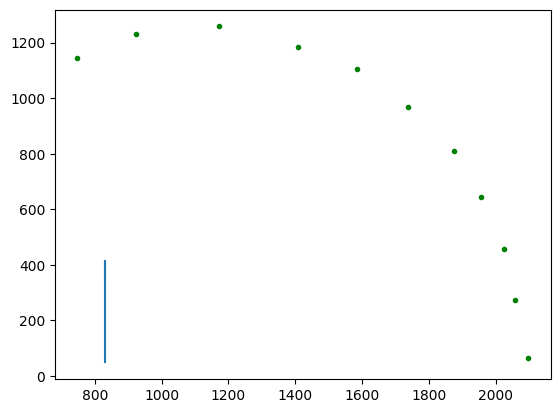

In [79]:
xx=df['Omega']
z_im=func_im(xx,*vec_popt_im[1000])
z_real=func_real(xx,*vec_popt_real[1000])
plt.plot(abs(z_real),abs(z_im))
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'g.')

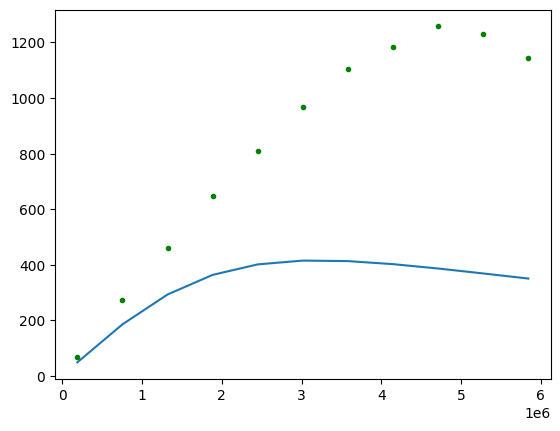

In [65]:
plt.plot(df['Omega'],np.abs(func_im(df['Omega'],*vec_popt_im[1000])))
plt.plot(df.Omega,df['Impedance_Imaginary'],'g.')

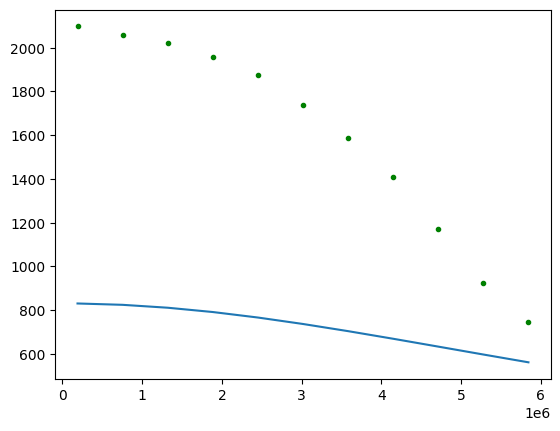

In [66]:
plt.plot(df['Omega'],np.abs(func_real(df['Omega'],*vec_popt_real[1000])))
plt.plot(df.Omega,df['Impedance_Real'],'g.')

## Loop para tentar achar a melhor aproximação para os parâmetros (saindo com a função imaginária)

In [51]:
vec_popt_real_2=np.zeros([1001,3])
vec_popt_im_2=np.zeros([1001,3])

# Saindo com a função imaginária

vec_popt_im_2[0], vec_pcov_im = scy.curve_fit(func_real, df.Omega, df.Impedance_Real,bounds=(0,[10**6,10**2,1]),maxfev=100000)
i=0
while i<1000:
    vec_popt_real_2[i+1], vec_pcov_real=scy.curve_fit(func_real, df.Omega, df.Impedance_Imaginary,p0=vec_popt_im_2[i],bounds=(vec_popt_im_2[i],np.inf))
    vec_popt_im_2[i+1], vec_pcov_im=scy.curve_fit(func_im, df.Omega, df.Impedance_Imaginary,p0=vec_popt_real_2[i+1],bounds=(vec_popt_real_2[i+1],np.inf))
    i=i+1

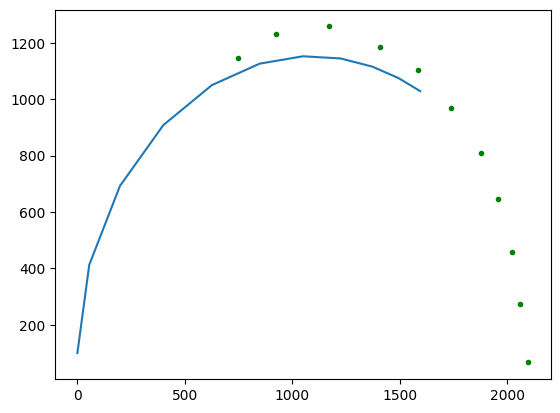

In [52]:
xx=df['Omega']
z_im=func_im(xx,*vec_popt_im_2[1000])
z_real=func_real(xx,*vec_popt_real_2[1000])
plt.plot(abs(z_real),abs(z_im))
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'g.')

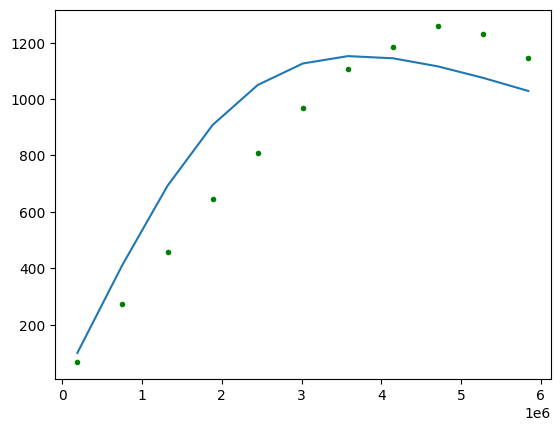

In [53]:
plt.plot(df['Omega'],np.abs(func_im(df['Omega'],*vec_popt_im_2[1000])))
plt.plot(df.Omega,df['Impedance_Imaginary'],'g.')

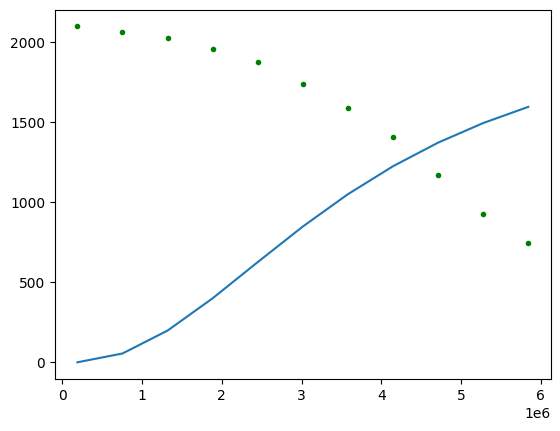

In [54]:
plt.plot(df['Omega'],np.abs(func_real(df['Omega'],*vec_popt_real_2[1000])))
plt.plot(df.Omega,df['Impedance_Real'],'g.')